# Lab 9: Design of Experiment
In this lab, we will observe the effect of the DoE in the Bayesian optimization and Bio-inspired approaches.

In the following (hidden) block, the utilities used for running the experiments are implemented.

The list of available benchmark functions can be found at this [link](https://gitlab.com/luca.baronti/python_benchmark_functions)

**NOTE**: When studying the effect of the parameters is *extremely* important to vary just one parameter at a time. Therefore, you are suggested to study one parameter by fixing all the others, and then moving to the next.

Moreover, when comparing different algorithms, is *very* important to run each of them several times (e.g., 30) by using different initial random seeds.


You will use the sampling technique seen in the lecture. In particular, you will have to implement:


*   Random sampling
*   The Halton sequence
*   The full factorial sampling
*   The Latin Hypercube sampling



In [4]:
!pip install cma
!pip install inspyred
!pip install benchmark_functions
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 KB 5.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 KB 4.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 KB 3.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 5.0 MB/s eta 0:00:00


Code for the Bayesian Optimization, you have to reuse the code from Lab. 6 for the acquisition and the objective functions.

In [30]:
#@title

# example of bayesian optimization for a 1d function from scratch
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

from numpy import mean
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Integer
from skopt.utils import use_named_args
from warnings import catch_warnings
from skopt import gp_minimize
from warnings import simplefilter




# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	print(X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# calculate the probability of improvement
	probs = acquisition_function()
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(100)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()


def bayesianOptmization(generation, generator_type, random, args):
    # sample the domain sparsely with noise
    X , y  = initial_point(generator_type, random, args)
    # reshape into rows and cols
    X = X.reshape(len(X), 1)
    y = y.reshape(len(y), 1)
    # define the model
    model = GaussianProcessRegressor() #you can set the kernel and the optmizer 
    # fit the model
    model.fit(X, y)
    # perform the optimization process
    for i in range(generation):
        # select the next point to sample
        x = opt_acquisition(X, y, model)
        # sample the point
        actual = objective(x)
        # summarize the finding
        est, _ = surrogate(model, [[x]])
        # add the data to the dataset
        X = vstack((X, [[x]]))
        y = vstack((y, [[actual]]))
        # update the model
        model.fit(X, y)
    return X, y, model

def generator(case):
    if case == "random":
        return random_generator
    if case == "LHS":
        return lhs_generator
    if case == "Halton":
        return Halton_generator
    if case == "FF":
        return ff_generator
		
# objective function
def objective(x, noise=0.1):
	return x + normal(loc=0, scale=noise)

#remember to return the value in the right order and type.
def initial_point(generator_type, random, args):
    # gen = generator(generator_type)
    X = generator(generator_type)(random, args)
    # X = gen(random,args)
    Y = asarray([objective(x) for x in X])
    return X, Y

#you have to add the parameters that you need.
def acquisition_function():
    return 0

Code for the Genetic algorithm from lab. 7

In [6]:
#@title
import cma
import inspyred
import importlib
import functools
import numpy as np
from pylab import *
from inspyred import ec
from copy import deepcopy
from functools import reduce
import benchmark_functions as bf
from matplotlib import pyplot as plt
from inspyred.ec import EvolutionaryComputation
from inspyred.ec import selectors, replacers, terminators


GLOBAL = 'Global'
INDIVIDUAL = 'Individual'
CORRELATED = 'Correlated'
STAR = 'star'
RING = 'ring'

class OptFun():
    def __init__(self, wf):
        self.f = wf
        self.history = []
        self.__name__ = f'OptFun({wf.__class__})'
        
    def __call__(self, candidates, *args, **kwargs):
        y = []
        for x0 in candidates:
            self.history.append(deepcopy(x0))
            y.append(self.f(x0))
        return y

    def minima(self):
        return self.f.minima()
        
    def bounder(self):
        def fcn(candidate, *args):
            bounds = self.f.suggested_bounds()
    
            for i, (m, M) in enumerate(zip(*bounds)):
                if candidate[i] < m:
                    candidate[i] = m
                if candidate[i] > M:
                    candidate[i] = M
            return candidate
        return fcn
        
    def bounds(self):
        return self._convert_bounds(self.f.suggested_bounds())

    def heatmap(self, fn = None):
        plt.clf()
        resolution = 50
        fig = plt.figure()
        fig.canvas.set_window_title('Benchmark Function: '+self.f._name)
        fig.suptitle(self.f._name)
        bounds_lower, bounds_upper = self.f.suggested_bounds()
        x = np.linspace(bounds_lower[0], bounds_upper[0], resolution)
        if self.f._n_dimensions>1:
            y = np.linspace(bounds_lower[1], bounds_upper[1], resolution)
            X, Y = np.meshgrid(x, y)
            Z = np.asarray([[self.f((X[i][j],Y[i][j])) for j in range(len(X[i]))] for i in range(len(X))])

        plt.contour(x,y,Z,15,linewidths=0.5,colors='k') # hight lines
        plt.contourf(x,y,Z,15,cmap='viridis', vmin=Z.min(), vmax=Z.max()) # heat map
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar()
        cbar.set_label('z')
        if len(self.history)>0:	# plot points
            xdata = [x[0] for x in self.history]
            ydata = [x[1] for x in self.history]
            plt.plot(xdata, ydata, "or-", markersize=2, linewidth=2)
        if fn is None:
            plt.show()
        else:
            plt.savefig(fn, dpi=400)

    def plot(self):
        plt.clf()
        values = [self.f(v) for v in self.history]
        min = func.minima()[0].score
        plt.plot(values)
        plt.axhline(min, color="r", label="optimum")
        plt.legend()
        plt.show()

    def _convert_bounds(self, bounds):
        new_bounds= []
        for i in range(len(bounds[0])):
            new_bounds.append((bounds[0][i], bounds[1][i]))
        return new_bounds
    
    def current_calls(self):
        return len(self.history)



def choice_without_replacement(rng, n, size) :
    result = set()
    while len(result) < size :
        result.add(rng.randint(0, n))
    return result

class NumpyRandomWrapper(RandomState):
    def __init__(self, seed=None):
        super(NumpyRandomWrapper, self).__init__(seed)
        
    def sample(self, population, k):
        if isinstance(population, int) :
            population = range(population)           
        
        return asarray([population[i] for i in 
                        choice_without_replacement(self, len(population), k)])
        #return #self.choice(population, k, replace=False)
        
    def random(self):
        return self.random_sample()
    
    def gauss(self, mu, sigma):
        return self.normal(mu, sigma)
    
def initial_pop_observer(population, num_generations, num_evaluations, 
                         args):
    if num_generations == 0 :
        args["initial_pop_storage"]["individuals"] = asarray([guy.candidate 
                                                 for guy in population]) 
        args["initial_pop_storage"]["fitnesses"] = asarray([guy.fitness 
                                          for guy in population]) 
        
def generator(case, random, args):
    if case == "random":
        args["sequence"] = random_generator(random, args)
    if case == "LHS":
        args["sequence"] = lhs_generator(random, args)
    if case == "Halton":
        args["sequence"] = Halton_generator(random, args)
    if case == "FF":
        args["sequence"] = ff_generator(random, args)
    args["index"] = 0
    return fake_generator

def fake_generator(random, args):
    index = args["index"]
    args["index"] += 1
    
    return args["sequence"][index]

def generator_wrapper(func):
        @functools.wraps(func)
        def _generator(random, args):
            return asarray(func(random, args))
        return _generator

def single_objective_evaluator(candidates, args):
    problem = args["problem"]
    return [CombinedObjectives(fit,args) for fit in 
            problem.evaluator(candidates, args)]
            
def run_ga(random, generator_type, func, num_vars=0,
           maximize=False, **kwargs) :
    
    #create dictionaries to store data about initial population, and lines
    initial_pop_storage = {}
    
    algorithm = ec.EvolutionaryComputation(random)
    algorithm.terminator = ec.terminators.generation_termination
    algorithm.replacer = ec.replacers.generational_replacement    
    algorithm.variator = [ec.variators.uniform_crossover,ec.variators.gaussian_mutation]
    algorithm.selector = ec.selectors.tournament_selection
    
    algorithm.observer = initial_pop_observer
    
    kwargs["num_selected"]=kwargs["pop_size"]

    kwargs["bounder"]=func.bounder()
    kwargs["generator"]= generator(generator_type, random, kwargs)
    final_pop = algorithm.evolve(evaluator=func,  
                          maximize=False,
                          initial_pop_storage=initial_pop_storage,
                          num_vars=num_vars,
                          **kwargs)

    #best_guy = final_pop[0].candidate
    #best_fitness = final_pop[0].fitness
    final_pop_fitnesses = asarray([guy.fitness for guy in final_pop])
    final_pop_candidates = asarray([guy.candidate for guy in final_pop])
    
    sort_indexes = sorted(range(len(final_pop_fitnesses)), key=final_pop_fitnesses.__getitem__)
    final_pop_fitnesses = final_pop_fitnesses[sort_indexes]
    final_pop_candidates = final_pop_candidates[sort_indexes]
    
    best_guy = final_pop_candidates[0]
    best_fitness = final_pop_fitnesses[0]

    return best_guy, best_fitness, final_pop




Samplings methods to implement

In [47]:
def halton(b):
    """Generator function for Halton sequence."""
    n, d = 0, 1
    while True:
        x = d - n
        if x == 1:
            n = 1
            d *= b
        else:
            y = d // b
            while x <= y:
                y //= b
            n = (b + 1) * y - x
        yield n / d

def random_generator(random, args):
    return random(args["size"])
def lhs_generator(random, args):
    pass
def Halton_generator(random, args):
    res = []
    for i in zip(range(args["size"]),halton(args["dim"])):
      res.append(i[1])
    return np.array(res)
def ff_generator(random, args):
    pass

#Exercise 1: Bayesian Optmization

[[0.5       ]
 [0.25      ]
 [0.75      ]
 [0.125     ]
 [0.625     ]
 [0.375     ]
 [0.875     ]
 [0.0625    ]
 [0.5625    ]
 [0.3125    ]
 [0.8125    ]
 [0.1875    ]
 [0.6875    ]
 [0.4375    ]
 [0.9375    ]
 [0.03125   ]
 [0.53125   ]
 [0.28125   ]
 [0.78125   ]
 [0.15625   ]
 [0.65625   ]
 [0.40625   ]
 [0.90625   ]
 [0.09375   ]
 [0.59375   ]
 [0.34375   ]
 [0.84375   ]
 [0.21875   ]
 [0.71875   ]
 [0.46875   ]
 [0.96875   ]
 [0.015625  ]
 [0.515625  ]
 [0.265625  ]
 [0.765625  ]
 [0.140625  ]
 [0.640625  ]
 [0.390625  ]
 [0.890625  ]
 [0.078125  ]
 [0.578125  ]
 [0.328125  ]
 [0.828125  ]
 [0.203125  ]
 [0.703125  ]
 [0.453125  ]
 [0.953125  ]
 [0.046875  ]
 [0.546875  ]
 [0.296875  ]
 [0.796875  ]
 [0.171875  ]
 [0.671875  ]
 [0.421875  ]
 [0.921875  ]
 [0.109375  ]
 [0.609375  ]
 [0.359375  ]
 [0.859375  ]
 [0.234375  ]
 [0.734375  ]
 [0.484375  ]
 [0.984375  ]
 [0.0078125 ]
 [0.5078125 ]
 [0.2578125 ]
 [0.7578125 ]
 [0.1328125 ]
 [0.6328125 ]
 [0.3828125 ]
 [0.8828125 ]
 [0.07

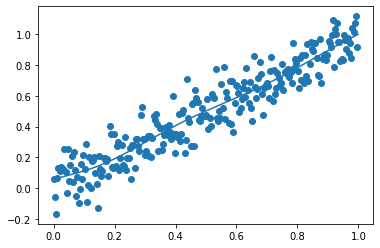

Best Result: x=0.992, y=1.117


In [48]:
from numpy.random import random

args = {}
args["size"] = 256
args["dim"] = 2

X, y, model = bayesianOptmization(1, "Halton", random=random, args=args)
plot(X, y, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

# Exercise 2: Genetic Algorithm

20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


<Figure size 432x288 with 0 Axes>

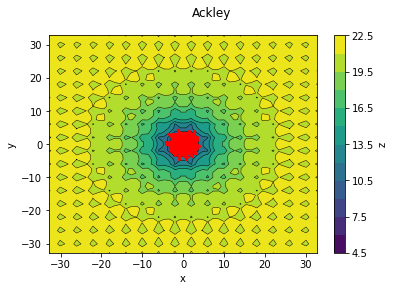

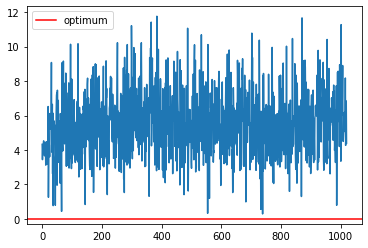

In [ ]:
from random import Random


func = OptFun(bf.Ackley(2))

args = {}
args["num_vars"] = 2 # Number of dimensions of the search space
args["gaussian_stdev"] = 1.0 # Standard deviation of the Gaussian mutations
args["tournament_size"] = 2 
args["num_elites"] = 1 # number of elite individuals to maintain in each gen
args["pop_size"] = 20 # population size
args["pop_init_range"] = func.bounds()[0] # Range for the initial population
args["max_generations"] = 50 # Number of generations of the GA
args["crossover_rate"] = 0.0
args["mutation_rate"] = 1.0

run_ga(
    Random(0),  # Seeded random number generator
    "random",
    func,
    **args
)

func.heatmap()
func.plot()

In this lab, you will need to compare the algorithms studied in the previous lessons with their version enhanced with different DOE techniques.

1.   How do the performances increases? Are the algorithms faster to converge, or can they find better solutions? 
2.   Is there an approach better than the others in terms of performance?
3.   How much do the DOEs affect the search cost? 
